#### Remaining Useful Life Estimation through feature engineering
feature engineering and regression modeling to predict battery capacity (C) at each cycle and then progressing to RUL estimation.

In [67]:

# Feature Engineering and ML Model for Battery RUL Prediction

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate

In [3]:
# Load metadata
data_path = '../data/metadata.csv'
metadata = pd.read_csv(data_path)

metadata['cycle_count'] = metadata['test_id'] # Feature: Cycle count (already present as test_id)


In [4]:
metadata.head()

,type,start_time,ambient_temperature,battery_id,test_id,uid,filename,Capacity,Re,Rct,cycle_count
0,charge,2008-04-02 13:08:17,24,B0005,0,1,00001.csv,NaN,NaN,NaN,0
1,discharge,2008-04-02 15:25:41,24,B0005,1,2,00002.csv,1.8564874208181574,NaN,NaN,1
2,charge,2008-04-02 16:37:51,24,B0005,2,3,00003.csv,NaN,NaN,NaN,2
3,discharge,2008-04-02 19:43:48,24,B0005,3,4,00004.csv,1.846327249719927,NaN,NaN,3
4,charge,2008-04-02 20:55:40,24,B0005,4,5,00005.csv,NaN,NaN,NaN,4


In [5]:
# Feature: Depth of Discharge (DoD) for discharge cycles using Capacity from metadata
nominal_capacity = 2.0  # Update if your battery's nominal capacity is different

# Ensure Capacity is numeric
metadata['Capacity'] = pd.to_numeric(metadata['Capacity'], errors='coerce')

metadata['DoD'] = np.where(
    (metadata['type'] == 'discharge') & (metadata['Capacity'].notnull()),
    (metadata['Capacity'] / nominal_capacity) * 100, 
    np.nan)

In [6]:
metadata.head()

,type,start_time,ambient_temperature,battery_id,test_id,uid,filename,Capacity,Re,Rct,cycle_count,DoD
0,charge,2008-04-02 13:08:17,24,B0005,0,1,00001.csv,NaN,NaN,NaN,0,NaN
1,discharge,2008-04-02 15:25:41,24,B0005,1,2,00002.csv,1.856487,NaN,NaN,1,92.824371
2,charge,2008-04-02 16:37:51,24,B0005,2,3,00003.csv,NaN,NaN,NaN,2,NaN
3,discharge,2008-04-02 19:43:48,24,B0005,3,4,00004.csv,1.846327,NaN,NaN,3,92.316362
4,charge,2008-04-02 20:55:40,24,B0005,4,5,00005.csv,NaN,NaN,NaN,4,NaN


In [ ]:
# Feature: Temperature statistics
def temp_stats(filename):
    try:
        df = pd.read_csv(f"../data/nasa_processed_data/{filename}")
        if 'Temperature_measured' in df.columns:
            return df['Temperature_measured'].mean(), df['Temperature_measured'].std()
        else:
            return np.nan, np.nan
    except Exception:
        return np.nan, np.nan
# Apply temperature statistics to metadata, mean teamperature and std
metadata[['temp_mean', 'temp_std']] = metadata.apply(
    lambda row: pd.Series(temp_stats(row['filename'])), axis=1
)

In [8]:
metadata.head()

,type,start_time,ambient_temperature,battery_id,test_id,uid,filename,Capacity,Re,Rct,cycle_count,DoD,temp_mean,temp_std
0,charge,2008-04-02 13:08:17,24,B0005,0,1,00001.csv,NaN,NaN,NaN,0,NaN,25.324079,1.011951
1,discharge,2008-04-02 15:25:41,24,B0005,1,2,00002.csv,1.856487,NaN,NaN,1,92.824371,32.572328,3.495804
2,charge,2008-04-02 16:37:51,24,B0005,2,3,00003.csv,NaN,NaN,NaN,2,NaN,26.635623,1.358494
3,discharge,2008-04-02 19:43:48,24,B0005,3,4,00004.csv,1.846327,NaN,NaN,3,92.316362,32.725235,3.435509
4,charge,2008-04-02 20:55:40,24,B0005,4,5,00005.csv,NaN,NaN,NaN,4,NaN,26.778176,1.371851


In [9]:
# Feature: Charge/Discharge rate (C-rate)
def c_rate(filename, nominal_capacity=2.0):
    try:
        df = pd.read_csv(f"../data/nasa_processed_data/{filename}")
        if 'Current_measured' in df.columns:
            return df['Current_measured'].abs().max() / nominal_capacity
        else:
            return np.nan
    except Exception:
        return np.nan

metadata['C_rate'] = metadata.apply(
    lambda row: c_rate(row['filename']), axis=1
)

In [10]:
metadata.head()

,type,start_time,ambient_temperature,battery_id,test_id,uid,filename,Capacity,Re,Rct,cycle_count,DoD,temp_mean,temp_std,C_rate
0,charge,2008-04-02 13:08:17,24,B0005,0,1,00001.csv,NaN,NaN,NaN,0,NaN,25.324079,1.011951,2.015134
1,discharge,2008-04-02 15:25:41,24,B0005,1,2,00002.csv,1.856487,NaN,NaN,1,92.824371,32.572328,3.495804,1.009007
2,charge,2008-04-02 16:37:51,24,B0005,2,3,00003.csv,NaN,NaN,NaN,2,NaN,26.635623,1.358494,1.680991
3,discharge,2008-04-02 19:43:48,24,B0005,3,4,00004.csv,1.846327,NaN,NaN,3,92.316362,32.725235,3.435509,1.008410
4,charge,2008-04-02 20:55:40,24,B0005,4,5,00005.csv,NaN,NaN,NaN,4,NaN,26.778176,1.371851,1.692204


In [11]:
# Only keep discharge cycles for RUL prediction
discharge_data = metadata[metadata['type'] == 'discharge'].copy()
discharge_data = discharge_data.reset_index(drop=True)

# Target: Remaining Useful Life (RUL) in cycles
discharge_data['RUL'] = discharge_data.groupby('battery_id')['cycle_count'].transform('max') - discharge_data['cycle_count']


In [12]:
discharge_data.head()

,type,start_time,ambient_temperature,battery_id,test_id,uid,filename,Capacity,Re,Rct,cycle_count,DoD,temp_mean,temp_std,C_rate,RUL
0,discharge,2008-04-02 15:25:41,24,B0005,1,2,00002.csv,1.856487,NaN,NaN,1,92.824371,32.572328,3.495804,1.009007,612
1,discharge,2008-04-02 19:43:48,24,B0005,3,4,00004.csv,1.846327,NaN,NaN,3,92.316362,32.725235,3.435509,1.008410,610
2,discharge,2008-04-03 00:01:06,24,B0005,5,6,00006.csv,1.835349,NaN,NaN,5,91.767460,32.642862,3.388174,1.008287,608
3,discharge,2008-04-03 04:16:37,24,B0005,7,8,00008.csv,1.835263,NaN,NaN,7,91.763126,32.514876,3.395306,1.007968,606
4,discharge,2008-04-03 08:33:25,24,B0005,9,10,00010.csv,1.834646,NaN,NaN,9,91.732275,32.382349,3.404667,1.008713,604


Features to be used for model creation: 
- Cycle count
- Depth of Discharge (DoD)
- Mean temperature
- Standard deviation of temperature
- Charge/discharge rate
- Ambient temperature
- Estimated electrolyte resistance Re and
- Estimated charge transfer resistance Rct 

In [ ]:
features = ['cycle_count', 'DoD', 'temp_mean', 'temp_std', 'C_rate', 'ambient_temperature']
#, 'Re', 'Rct' are empty for dischage cycles
target = 'RUL'


In [18]:
# Remove 'Re' and 'Rct' from features if they are all NaN
selected_features = [f for f in features if f not in ['Re', 'Rct']]

model_data = discharge_data[selected_features + [target]].dropna().reset_index(drop=True)
X = model_data[selected_features]
y = model_data[target]

# test data and tranining data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [26]:
# Train using Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=19)
rf_model.fit(X_train, y_train)

# Predictions
y_prediction = rf_model.predict(X_test)

# Evaluation
mae = mean_absolute_error(y_test, y_prediction)
mse = mean_squared_error(y_test, y_prediction)
rmse = np.sqrt(mse) # root mean squared error
r2 = r2_score(y_test, y_prediction)

In [27]:
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R-squared: {r2:.2f}")

MAE: 9.12
MSE: 669.89
RMSE: 25.88
R-squared: 0.97


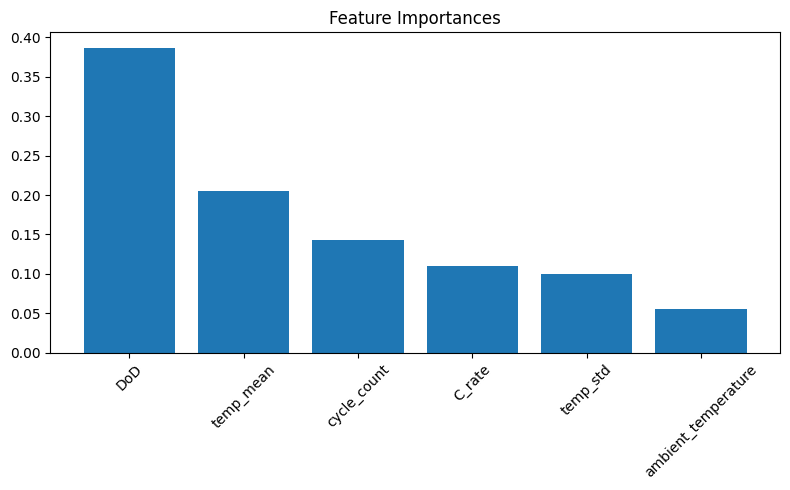

In [28]:
# Feature Importance
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(8, 5))
plt.title("Feature Importances")
plt.bar(range(len(selected_features)), importances[indices], align="center")
plt.xticks(range(len(selected_features)), [selected_features[i] for i in indices], rotation=45)
plt.tight_layout()
plt.show()


In [30]:
# Model  Training usinf Extra Trees Regression
from sklearn.ensemble import ExtraTreesRegressor
# Train using Extra Trees Regressor model
etr_model = ExtraTreesRegressor(n_estimators=100, random_state=19)
etr_model.fit(X_train, y_train)

# Predictions
y_prediction = etr_model.predict(X_test)

# Evaluation
mae_etr = mean_absolute_error(y_test, y_prediction)
mse_etr = mean_squared_error(y_test, y_prediction)
rmse_etr = np.sqrt(mse_etr) # root mean squared error
r2_etr = r2_score(y_test, y_prediction)

In [31]:
print(f"MAE: {mae_etr:.2f}")
print(f"MSE: {mse_etr:.2f}")
print(f"RMSE: {rmse_etr:.2f}")
print(f"R-squared: {r2_etr:.2f}")

MAE: 5.00
MSE: 359.30
RMSE: 18.96
R-squared: 0.98


In [32]:
# Model  Training using K Nearest Neighbors Regression
from sklearn.neighbors import KNeighborsRegressor

#Training
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train, y_train)

# Predictions
y_prediction = knn_model.predict(X_test)

# Evaluation
mae_knn = mean_absolute_error(y_test, y_prediction)
mse_knn = mean_squared_error(y_test, y_prediction)
rmse_knn = np.sqrt(mse_knn) # root mean squared error
r2_knn = r2_score(y_test, y_prediction)

In [33]:
print(f"MAE_knn: {mae_knn:.2f}")
print(f"MSE_knn: {mse_knn:.2f}")
print(f"RMSE_knn: {rmse_knn:.2f}")
print(f"R-squared_knn: {r2_knn:.2f}")

MAE_knn: 31.42
MSE_knn: 3593.03
RMSE_knn: 59.94
R-squared_knn: 0.82


In [ ]:
# Model training using XGBoost Regressor
from sklearn.ensemble import GradientBoostingRegressor

# Training
gbr_model = GradientBoostingRegressor(n_estimators=100, random_state=19)
gbr_model.fit(X_train, y_train)
# Predictions
y_prediction = gbr_model.predict(X_test)
# Evaluation
mae_gbr = mean_absolute_error(y_test, y_prediction)
mse_gbr = mean_squared_error(y_test, y_prediction)
rmse_gbr = np.sqrt(mse_gbr) # root mean squared error
r2_gbr = r2_score(y_test, y_prediction)
print(f"MAE_gbr: {mae_gbr:.2f}")
print(f"MSE_gbr: {mse_gbr:.2f}")
print(f"RMSE_gbr: {rmse_gbr:.2f}")
print(f"R-squared_gbr: {r2_gbr:.2f}")

MAE_gbr: 32.96
MSE_gbr: 2242.77
RMSE_gbr: 47.36
R-squared_gbr: 0.89


In [36]:
# train using XGBoost Regressor
from xgboost import XGBRegressor
# Training
xgb_model = XGBRegressor(n_estimators=100, random_state=19)
xgb_model.fit(X_train, y_train)
# Predictions
y_prediction = xgb_model.predict(X_test)
# Evaluation
mae_xgb = mean_absolute_error(y_test, y_prediction)
mse_xgb = mean_squared_error(y_test, y_prediction)
rmse_xgb = np.sqrt(mse_xgb) # root mean squared error
r2_xgb = r2_score(y_test, y_prediction)
print(f"MAE_xgb: {mae_xgb:.2f}")
print(f"MSE_xgb: {mse_xgb:.2f}")
print(f"RMSE_xgb: {rmse_xgb:.2f}")
print(f"R-squared_xgb: {r2_xgb:.2f}")

MAE_xgb: 13.24
MSE_xgb: 894.92
RMSE_xgb: 29.92
R-squared_xgb: 0.96


In [39]:
#Training using Long Short-term Memory LSTM Network
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
# Reshape data for LSTM
X_train_lstm = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))
# Scale the data
scaler = MinMaxScaler()
X_train_lstm = scaler.fit_transform(X_train_lstm.reshape(-1, X_train_lstm.shape[-1])).reshape(X_train_lstm.shape)
X_test_lstm = scaler.transform(X_test_lstm.reshape(-1, X_test_lstm.shape[-1])).reshape(X_test_lstm.shape)
# Build LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
# Train LSTM model
lstm_model.fit(X_train_lstm, y_train, epochs=50, batch_size=32, verbose=1)
# Predictions
y_prediction = lstm_model.predict(X_test_lstm)
# Evaluation
mae_lstm = mean_absolute_error(y_test, y_prediction)
mse_lstm = mean_squared_error(y_test, y_prediction)
rmse_lstm = np.sqrt(mse_lstm) # root mean squared error
r2_lstm = r2_score(y_test, y_prediction)
print(f"MAE_lstm: {mae_lstm:.2f}")
print(f"MSE_lstm: {mse_lstm:.2f}")
print(f"RMSE_lstm: {rmse_lstm:.2f}")
print(f"R-squared_lstm: {r2_lstm:.2f}")


Epoch 1/50


c:\Users\pushk\miniconda3\envs\devenvpy10\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 51529.6484
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 33441.2227
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 24929.2578
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 22976.9766
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 24063.1797
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 21888.0684
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 22861.0469
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 22193.8828
Epoch 9/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 22902.7363
Epoch 10/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 22498.3535
Epoch 11/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 21923.4629
Epoch 12/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 21754.3848
Epoch 13/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 22501.3789
Epoch 14/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 22089.9883
Epoch 15/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0

In [41]:
#Table comparison for all models
model_comparison = pd.DataFrame({
    'Model': ['Random Forest', 'Extra Trees', 'KNN', 'Gradient Boosting', 'XGBoost', 'LSTM'],
    'MAE': [mae, mae_etr, mae_knn, mae_gbr, mae_xgb, mae_lstm],
    'MAE': [mae, mae_etr, mae_knn, mae_gbr, mae_xgb, mae_lstm],
    'MSE': [mse, mse_etr, mse_knn, mse_gbr, mse_xgb, mse_lstm],
    'RMSE': [rmse, rmse_etr, rmse_knn, rmse_gbr, rmse_xgb, rmse_lstm],
    'R-squared': [r2, r2_etr, r2_knn, r2_gbr, r2_xgb, r2_lstm]
})

In [42]:
model_comparison

,Model,MAE,MSE,RMSE,R-squared
0,Random Forest,9.121751,669.889850,25.882230,0.966841
1,Extra Trees,4.999549,359.300308,18.955218,0.982215
2,KNN,31.424549,3593.025848,59.941854,0.822150
3,Gradient Boosting,32.962111,2242.769093,47.357883,0.888986
4,XGBoost,13.238990,894.919739,29.915209,0.955703
5,LSTM,115.795486,19531.574219,139.755409,0.033212


##### Based on comparison of initial evaluation, Extra Trees Regression Model performs the best with these evaluations:
- MAE=4.9 
- RMSE=18.9 (Outliers estimates) 
- R-squared=0.98 (very good fit, can explain 98% of the variance in RUL)

In [45]:
#Model Training using GridSearchCV for Exrta Trees Regressor
# hyperparameter tuning

etr_model = ExtraTreesRegressor(random_state=19)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(etr_model, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)
# Best parameters
print("Best parameters found: ", grid_search.best_params_)
best_etr_model = grid_search.best_estimator_
# Predictions
y_prediction = best_etr_model.predict(X_test)
# Evaluation
mae_best_etr = mean_absolute_error(y_test, y_prediction)
mse_best_etr = mean_squared_error(y_test, y_prediction)
rmse_best_etr = np.sqrt(mse_best_etr) # root mean squared error
r2_best_etr = r2_score(y_test, y_prediction)

print(f"MAE_best_etr: {mae_best_etr:.2f}")
print(f"MSE_best_etr: {mse_best_etr:.2f}")
print(f"RMSE_best_etr: {rmse_best_etr:.2f}")
print(f"R-squared_best_etr: {r2_best_etr:.2f}")


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters found:  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
MAE_best_etr: 8.42
MSE_best_etr: 379.77
RMSE_best_etr: 19.49
R-squared_best_etr: 0.98


The results remained almost similar after hyperparameter tuning.

We will try a Neural Network Model (MLP Regressor), where we will have more options of modifications.

In [ ]:
# Neural Network (MLPRegressor) with hyperparameter tuning
mlp_param_grid = {
    'hidden_layer_sizes': [(32,), (64,), (128,), (64, 32), (128, 64), (128, 64, 32)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001, 0.01],  # L2 regularization
    'learning_rate_init': [0.001, 0.01, 0.1],
    'max_iter': [500],
}
mlp = MLPRegressor(random_state=19)
mlp_search = RandomizedSearchCV(mlp, mlp_param_grid, n_iter=20, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1, random_state=19)
mlp_search.fit(X_train, y_train)

best_mlp = mlp_search.best_estimator_
y_pred = best_mlp.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print('Best MLP Parameters:', mlp_search.best_params_)
print(f"MAE (MLP): {mae:.2f}")
print(f"MSE (MLP): {mse:.2f}")
print(f"RMSE (MLP): {rmse:.2f}")
print(f"R-squared (MLP): {r2:.2f}")


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best MLP Parameters: {'solver': 'adam', 'max_iter': 500, 'learning_rate_init': 0.001, 'hidden_layer_sizes': (64, 32), 'alpha': 0.001, 'activation': 'relu'}
MAE (MLP): 38.88
MSE (MLP): 3159.06
RMSE (MLP): 56.21
R² (MLP): 0.84


The results are worse than Extra Trees Regressor algorithms. 

Trial to further improve MLP Regressor with hyperparameters:
- Scaling of features before training the MLP
- Broader hyperparameter search
- Early stopping and more iterations.

In [52]:
#Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Expanding hyperparameter tunings
mlp_param_grid = {
    'hidden_layer_sizes': [
        (32,), (64,), (128,), (256,), (64, 32), (128, 64), (128, 64, 32), (256, 128, 64)
    ],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam', 'lbfgs'],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'learning_rate_init': [0.0005, 0.001, 0.005, 0.01],
    'max_iter': [1000],
    'early_stopping': [True]
}

In [54]:
mlp = MLPRegressor(random_state=19)
mlp_search = RandomizedSearchCV(
    mlp, mlp_param_grid, n_iter=40, cv=3, scoring='neg_mean_absolute_error',
    n_jobs=-1, verbose=1, random_state=19
)
mlp_search.fit(X_train_scaled, y_train)

best_mlp = mlp_search.best_estimator_
y_pred = best_mlp.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print('Best MLP Parameters:', mlp_search.best_params_)
print(f"MAE (MLP): {mae:.2f}")
print(f"MSE (MLP): {mse:.2f}")
print(f"RMSE (MLP): {rmse:.2f}")
print(f"R-squared (MLP): {r2:.2f}")

Fitting 3 folds for each of 40 candidates, totalling 120 fits
Best MLP Parameters: {'solver': 'lbfgs', 'max_iter': 1000, 'learning_rate_init': 0.005, 'hidden_layer_sizes': (128, 64, 32), 'early_stopping': True, 'alpha': 0.001, 'activation': 'relu'}
MAE (MLP): 7.10
MSE (MLP): 389.09
RMSE (MLP): 19.73
R-squared (MLP): 0.98


c:\Users\pushk\miniconda3\envs\devenvpy10\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Now the results are comparable to **Extra trees Model**. 

Let's see if Model performance can be further improved.
- Increase max iterations
- Features engg:
  Ambient temperature feature has importance less than 0.10
  (From Extra trees result)
  Trial of result after removing this feature 
- Cross-validation (increment)

In [58]:
selected_features

['cycle_count',
 'DoD',
 'temp_mean',
 'temp_std',
 'C_rate',
 'ambient_temperature']

In [59]:
#ignoring ambient temperature
model_data = discharge_data[selected_features[:-1] + [target]].dropna().reset_index(drop=True)
X = model_data[selected_features[:-1]]
y = model_data[target]

# test data and tranining data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19)

In [61]:
#Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#hyperparameter tunings
mlp_param_grid = {
    'hidden_layer_sizes': [
        (32,), (64,), (128,), (256,), (64, 32), (128, 64), (128, 64, 32), (256, 128, 64)
    ],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam', 'lbfgs','sgd'],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'learning_rate_init': [0.0005, 0.001, 0.005, 0.01],
    'max_iter': [1000, 2000, 3000],
    'batch_size': [16, 32, 64],# used for 'sgd' solver
    # 'momentum': [0.9, 0.95],
    # 'nesterovs_momentum': [True, False],
    'learning_rate': ['constant', 'adaptive'], # used for sgd or adam 
    # 'power_t': [0.5, 0.9], 
    # 'tol': [1e-4, 1e-5],
    # 'max_fun': [15000],
    # 'shuffle': [True, False],
    # 'validation_fraction': [0.1, 0.2],
    'early_stopping': [True]
}

mlp = MLPRegressor(random_state=19)
mlp_search = RandomizedSearchCV(
    mlp, mlp_param_grid, n_iter=40, cv=5, scoring='neg_mean_absolute_error',
    n_jobs=-1, verbose=1, random_state=19
)
mlp_search.fit(X_train_scaled, y_train)

best_mlp = mlp_search.best_estimator_
y_pred = best_mlp.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print('Best MLP Parameters:', mlp_search.best_params_)
print(f"MAE (MLP): {mae:.2f}")
print(f"MSE (MLP): {mse:.2f}")
print(f"RMSE (MLP): {rmse:.2f}")
print(f"R-squared (MLP): {r2:.2f}")

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best MLP Parameters: {'solver': 'lbfgs', 'max_iter': 1000, 'learning_rate_init': 0.0005, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (64, 32), 'early_stopping': True, 'batch_size': 16, 'alpha': 0.0001, 'activation': 'relu'}
MAE (MLP): 8.70
MSE (MLP): 771.86
RMSE (MLP): 27.78
R-squared (MLP): 0.96


c:\Users\pushk\miniconda3\envs\devenvpy10\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


c:\Users\pushk\miniconda3\envs\devenvpy10\lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 2 is smaller than n_iter=40. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best MLP Parameters: {'solver': 'adam', 'max_iter': 2000, 'learning_rate_init': 0.001, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (256, 128, 64), 'early_stopping': True, 'batch_size': 16, 'alpha': 0.0001, 'activation': 'relu'}
Prediction with MLP - MAE: 12.6337, RMSE: 29.1789, R2: 0.9571


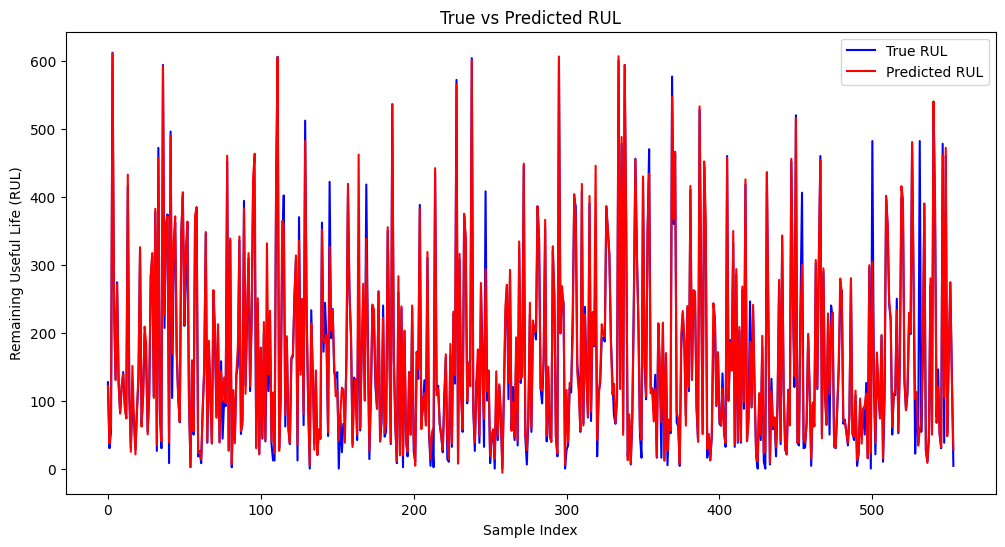

In [69]:
#hyperparameter tunings
mlp_param_grid = {
    'hidden_layer_sizes': [
        (256, 128, 64)
    ], #(32,), (64,), (128,), (256,), (64, 32),(128, 64), (128, 64, 32),
    'activation': ['relu'], #, 'tanh', 'logistic'
    'solver': [ 'sgd','adam'], # 'sgd','lbfgs, Try with sgd only
    'alpha': [0.0001], #, 0.001, 0.01, 0.1
    'learning_rate_init': [0.001],#[0.0005, 0.001, 0.005, 0.01],
    'max_iter': [ 2000], #1000, 3000
    'batch_size': [16], # ,32, 64 used for 'sgd' solver
    # 'momentum': [0.9, 0.95],
    # 'nesterovs_momentum': [True, False],
    'learning_rate': [ 'adaptive'], # 'constant', used for sgd or adam 
    # 'power_t': [0.5, 0.9], 
    # 'tol': [1e-4, 1e-5],
    # 'max_fun': [15000],
    # 'shuffle': [True, False],
    # 'validation_fraction': [0.1, 0.2],
    'early_stopping': [True]
}

mlp = MLPRegressor(random_state=19)
mlp_search = RandomizedSearchCV(
    mlp, mlp_param_grid, n_iter=40, cv=5, scoring='neg_mean_absolute_error',
    n_jobs=-1, verbose=1, random_state=19
)
mlp_search.fit(X_train_scaled, y_train)

best_mlp = mlp_search.best_estimator_
y_pred = best_mlp.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print('Best MLP Parameters:', mlp_search.best_params_)
print(f"Prediction with MLP - MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")
# # Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='True RUL', color='blue')
plt.plot(y_pred, label='Predicted RUL', color='red')
plt.title('True vs Predicted RUL')
plt.xlabel('Sample Index')
plt.ylabel('Remaining Useful Life (RUL)')
plt.legend()
plt.show()


In [70]:
best_mlp

MLPRegressor(batch_size=16, early_stopping=True,
             hidden_layer_sizes=(256, 128, 64), learning_rate='adaptive',
             max_iter=2000, random_state=19)

#### Hyperparamets tuning experimentations
- max_iteration = 2000 
-- MAE: 6.62, RMSE: 28.53, R2: 0.96
- max_iteration =
-- MAE: 6.62, RMSE: 28.53, R2: 0.96
- solver 'adam'
-- MAE: 12.6337, RMSE: 29.1789, R2: 0.9571


In [71]:
# 1. Cross-Validation (on best Extra Trees and MLP models)
cv = 5
# cv_scores_rf = cross_validate(best_rf, X_rul, y_rul, cv=cv, scoring=['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2'], return_train_score=True)
cv_scores_mlp = cross_validate(best_mlp, scaler.transform(X), y, cv=cv, scoring=['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2'], return_train_score=True)

# print(f"\nRandom Forest {cv}-fold CV Results:")
# print(f"MAE: {-cv_scores_rf['test_neg_mean_absolute_error'].mean():.2f} ± {cv_scores_rf['test_neg_mean_absolute_error'].std():.2f}")
# print(f"RMSE: {np.sqrt(-cv_scores_rf['test_neg_mean_squared_error'].mean()):.2f}")
# print(f"R²: {cv_scores_rf['test_r2'].mean():.2f}")

print(f"\nMLPRegressor {cv}-fold CV Results:")
print(f"MAE: {-cv_scores_mlp['test_neg_mean_absolute_error'].mean():.2f} ± {cv_scores_mlp['test_neg_mean_absolute_error'].std():.2f}")
print(f"RMSE: {np.sqrt(-cv_scores_mlp['test_neg_mean_squared_error'].mean()):.2f}")
print(f"R²: {cv_scores_mlp['test_r2'].mean():.2f}")


MLPRegressor 5-fold CV Results:
MAE: 103.35 ± 50.69
RMSE: 153.08
R²: -0.34


In [74]:
# Cross-Validation (on best Extra Trees and MLP models)
cv_scores_etr = cross_validate(best_etr_model, scaler.transform(X), y, cv=cv, scoring=['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2'], return_train_score=True)

# cv_scores_lstm = cross_validate(lstm_model, X.values.reshape((X.shape[0], X.shape[1], 1)), y, cv=cv, scoring=['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2'], return_train_score=True)
cv_scores_xgb = cross_validate(xgb_model, X, y, cv=cv, scoring=['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2'], return_train_score=True)
cv_scores_gbr = cross_validate(gbr_model, X, y, cv=cv, scoring=['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2'], return_train_score=True)
cv_scores_knn = cross_validate(knn_model, X, y, cv=cv, scoring=['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2'], return_train_score=True)
cv_scores_rf = cross_validate(rf_model, X, y, cv=cv, scoring=['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2'], return_train_score=True)



In [75]:
# Present results in a DataFrame format
cv_results_df = pd.DataFrame({
    'Model': ['Extra Trees', 'MLPRegressor', 'XGBoost', 'Gradient Boosting', 'KNN', 'Random Forest'], #LSTM not included due to reshape issues
    'MAE': [
        -cv_scores_etr['test_neg_mean_absolute_error'].mean(),
        -cv_scores_mlp['test_neg_mean_absolute_error'].mean(),
        # -cv_scores_lstm['test_neg_mean_absolute_error'].mean(),
        -cv_scores_xgb['test_neg_mean_absolute_error'].mean(),
        -cv_scores_gbr['test_neg_mean_absolute_error'].mean(),
        -cv_scores_knn['test_neg_mean_absolute_error'].mean(),
        -cv_scores_rf['test_neg_mean_absolute_error'].mean()
    ],
    'RMSE': [
        np.sqrt(-cv_scores_etr['test_neg_mean_squared_error'].mean()),
        np.sqrt(-cv_scores_mlp['test_neg_mean_squared_error'].mean()),
        # np.sqrt(-cv_scores_lstm['test_neg_mean_squared_error'].mean()),
        np.sqrt(-cv_scores_xgb['test_neg_mean_squared_error'].mean()),
        np.sqrt(-cv_scores_gbr['test_neg_mean_squared_error'].mean()),
        np.sqrt(-cv_scores_knn['test_neg_mean_squared_error'].mean()),
        np.sqrt(-cv_scores_rf['test_neg_mean_squared_error'].mean())
    ],
    'R²': [
        cv_scores_etr['test_r2'].mean(),
        cv_scores_mlp['test_r2'].mean(),
        # cv_scores_lstm['test_r2'].mean(),
        cv_scores_xgb['test_r2'].mean(),
        cv_scores_gbr['test_r2'].mean(),
        cv_scores_knn['test_r2'].mean(),
        cv_scores_rf['test_r2'].mean()
    ]
})

In [76]:
cv_results_df

,Model,MAE,RMSE,R²
0,Extra Trees,100.946904,141.188150,-0.199741
1,MLPRegressor,103.347063,153.080627,-0.341533
2,XGBoost,117.719128,172.517867,-0.646017
3,Gradient Boosting,119.001493,170.940596,-0.658204
4,KNN,113.926278,171.813813,-0.768956
5,Random Forest,104.520952,159.183440,-0.567216


### Residual Analysis

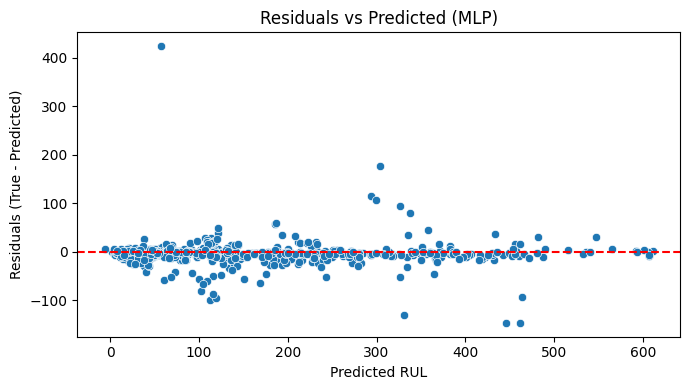

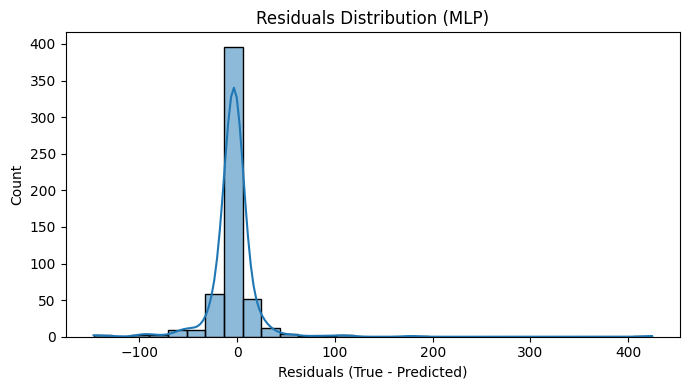

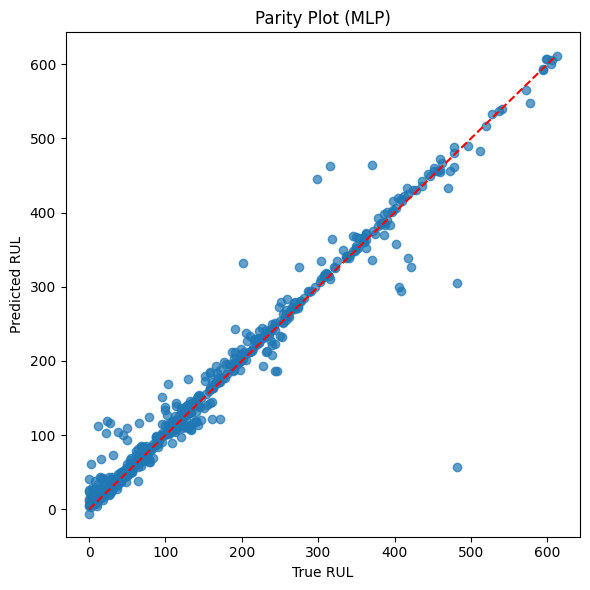

In [86]:
# 2. Residual Analysis (for best MLP on test set)
residuals = y_test - y_pred
plt.figure(figsize=(7,4))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted RUL')
plt.ylabel('Residuals (True - Predicted)')
plt.title('Residuals vs Predicted (MLP)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,4))
sns.histplot(residuals, bins=30, kde=True)
plt.xlabel('Residuals (True - Predicted)')
plt.title('Residuals Distribution (MLP)')
plt.tight_layout()
plt.show()

# 3. Parity Plot (Predicted vs True)
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('True RUL')
plt.ylabel('Predicted RUL')
plt.title('Parity Plot (MLP)')
plt.tight_layout()
plt.show()

### Results not as expected, data is overfitted. let's try a different approach at machine learning model creation